# Entrenamiento de Autoencoder y guardado de parámetros

En este notebook se entrena un autoencoder convolucional sobre FashionMNIST, se registran las pérdidas de entrenamiento y validación y se guardan los parámetros del modelo para luego ser reutilizados desde `train.ipynb` en una red clasificadora.

In [1]:
# 1) Instalación de librerías requeridas
!pip3 install torch torchvision torchaudio torchviz

In [2]:
# 2) Importar librerías necesarias
# 1.1)
import os
import pickle
import datetime
from collections import defaultdict

# 1.3)
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

# Configuración de dispositivo
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
# 2.1)
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

root_data = "MNIST_data/"
# Download and load the full training data
full_dataset = datasets.FashionMNIST('MNIST_data/', download=True, train=True, transform=transform)

# Split the full dataset into train and validation sets of (almost) equal size
train_size = len(full_dataset) // 2
valid_size = len(full_dataset) - train_size
train_set_orig_autoencoder, valid_set_orig_autoencoder = random_split(full_dataset, [train_size, valid_size])

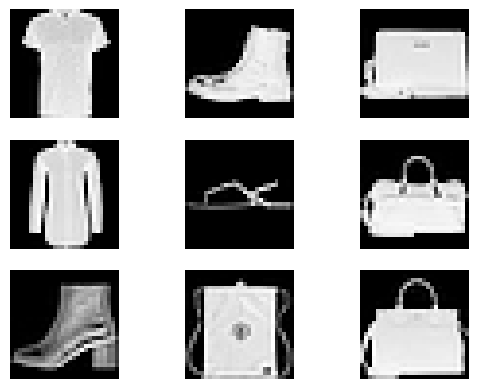

In [4]:
# 2.2)
import matplotlib.pyplot as plt
from matplotlib import cm

figure = plt.figure()
cols,rows = 3,3
for i in range(1,cols*rows+1):
    j = torch.randint(len(train_set_orig_autoencoder),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    image,label = train_set_orig_autoencoder[j]
    figure.add_subplot(rows,cols,i)
    #plt.title(labels_names[label])
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
plt.show()

In [5]:
# 3.1)
# Creamos una subclase de la clase Dataset que nos sirva para generar lotes de ejemplos que puedan usarse para entrenar un autoencoder
class CustomDataset(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    # Redefinimos el método .__len__()
    def __len__(self):
        return len(self.dataset)
    # Redefinimos el método .__getitem__()
    def __getitem__(self,i):
        image,label=self.dataset[i]
        input  = image
        output = image #torch.flatten(image) # retornamos la imagen como salida
        return input,output

In [6]:
# 3.2)
# Convertimos FashionMNIST Dataset a CustomDataset
train_set_autoencoder = CustomDataset(train_set_orig_autoencoder)
valid_set_autoencoder = CustomDataset(valid_set_orig_autoencoder)

print(f"Tamaño train_set: {len(train_set_autoencoder)}")
print(f"Tamaño valid_set: {len(valid_set_autoencoder)}")

Tamaño train_set: 30000
Tamaño valid_set: 30000


In [7]:
# 3) Definir modelo Autoencoder
class Autoencoder(nn.Module):
    """Experimento 1: Autoencoder convolucional básico"""

    def __init__(self, dropout = 0.15):
        super().__init__()
        # Encoder: (1, 28, 28) -> (32, 14, 14) -> (64, 7, 7)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),  # (1, 28, 28) -> (32, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (32, 28, 28) -> (32, 14, 14)
            nn.Dropout(dropout),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # (32, 14, 14) -> (64, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 14, 14) -> (64, 7, 7)
        )

        # Decoder: (64, 7, 7) -> (32, 14, 14) -> (1, 28, 28)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2),  # (64, 7, 7) -> (32, 14, 14)
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=2, stride=2),  # (32, 14, 14) -> (1, 28, 28)
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
# Crear instancia de modelo
p_dropout = 0.15
autoencoder = Autoencoder(dropout=p_dropout).to(device)
print(autoencoder)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.15, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)


In [9]:
# 5.1)
# Definimos la función de entrenamiento
def train_loop(dataloader, model, loss_fn, optimizer,verbose=True):
    # Activamos la maquinaria de entrenamiento del modelo
    model.train()
    # Definimos ciertas constantes
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss = 0
    sum_samples = 0
    # Movemos el modelo a la GPU si es que está disponible
    model = model.to(device)
    #Iteramos sobre lotes (batchs)
    for batch, (X,y) in enumerate(dataloader):
        # Copiamos las entradas y salidas al dispositvo de trabajo si es que está disponible
        X = X.to(device)
        y = y.to(device)
        batch_size = len(X)
        sum_samples += batch_size
        # Calculamos la predicción del modelo y la correspondiente función de pérdida
        pred = model(X)
        loss = loss_fn(pred,y)
        # Backpropagamos usando el optimizaor provisto
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Calculamos la pérdida promedio del batch y lo agregamos a una suma correspondiente
        sum_loss += loss.item() * batch_size
        # Reportamos el progreso
        if batch % (num_batches/10) == 0 and verbose:
            current = batch*len(X)
            avrg_loss = sum_loss/sum_samples
            print(f'@train_loop batch={batch:>5d} loss={avrg_loss:>7f} proccesed samples={100*sum_samples/num_samples:>5f}%')
    avrg_loss = sum_loss/num_samples
    return avrg_loss


In [10]:
# 5.2)
# De manera similar, definimos la función de validación
def eval_loop(dataloader,model,loss_fn):
  # Desactivamos la maquinaria e entrenamiento del modelo
  model.eval()
  # Definimos ciertas constantes
  num_samples = len(dataloader.dataset)
  num_batches = len(dataloader)
  sum_loss = 0
  sum_samples = 0
  # Movemos el modelo a la GPU si es que está disponible
  model = model.to(device)
  # Para testear, desactivmos el cálculo de gradientes
  with torch.no_grad():
    # Iteramos sobre lotes (batches)
    for X,y in dataloader:
      # Copiamos las entradas y salidas al dispositvo de trabajo si es que está disponible
      X = X.to(device)
      y = y.to(device)
      batch_size = len(X)     # number of samples in the batch
      sum_samples += batch_size
      # Calculamos las predicciones del modelo
      pred = model(X)
      loss = loss_fn(pred,y)
      # Calculamos la pérdida promedio del batch y lo agregamos a una suma correspondiente
      sum_loss += loss.item() * batch_size
  # Calculamos la pérdida total y la fracción de clasificaciones correctas y las imprimimos
  avrg_loss = sum_loss/sum_samples
  #print(f'@eval loop avrg loss={avg loss:>8f}')
  return avrg_loss


In [11]:
# 4) Preparar Dataset y DataLoader
batch_size = 100
train_loader_autoencoder = DataLoader(train_set_autoencoder, batch_size=batch_size, shuffle=True)
valid_loader_autoencoder = DataLoader(valid_set_autoencoder, batch_size=batch_size, shuffle=False)


num_train_batches = len(train_loader_autoencoder)
num_valid_batches = len(valid_loader_autoencoder)
print(f'num_train_batches={num_train_batches}')
print(f'num_valid_batches={num_valid_batches}')

num_train_batches=300
num_valid_batches=300


In [12]:
# 5) Definir loops de entrenamiento y validación
loss_fn = nn.MSELoss()

In [13]:
# 5.6)
# Creamos un optimizador, un Stochastic Gradient Descent o un ADAM
learning_rate = 1e-3
#optimizer = torch.optim.SGD(model.parameter(),lr=learning_rate)
optimizer = torch.optim.Adam(autoencoder.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

In [14]:
# 5.7)
# Determinamos en que dispositivo vamos a trabajar, con una CPU o GPU
devide = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Pasamos el modelo al dispositivo
autoencoder = autoencoder.to(device)

In [15]:
# 6) Entrenar Autoencoder y guardar parámetros
num_epochs = 50
list_avg_train_loss_incorrecta = []
list_avg_train_loss = []
list_avg_valid_loss = []
for epoch in range(num_epochs):
  print(f'Epoch {epoch+1}\n-------------------------------')
  avg_train_loss_incorrecta = train_loop(train_loader_autoencoder,autoencoder,loss_fn,optimizer)
  avg_train_loss = eval_loop(train_loader_autoencoder,autoencoder,loss_fn)
  avg_valid_loss = eval_loop(valid_loader_autoencoder,autoencoder,loss_fn)
  list_avg_train_loss_incorrecta.append(avg_train_loss_incorrecta)
  list_avg_train_loss.append(avg_train_loss)
  list_avg_valid_loss.append(avg_valid_loss)
  print('avg_train_loss_incorrecta.append=',avg_train_loss_incorrecta)
  print('avg_train_loss.append=',avg_train_loss)
  print('avg_valid_loss.append=',avg_valid_loss)
print('Done!')

# Preparar carpeta de salida (elige la ruta donde guardarás el checkpoint)
output_dir = "/home/usuario/Documentos/RedesNeuronales/TPFinal/Clasificadora/1_design"
os.makedirs(output_dir, exist_ok=True)

checkpoint = {
    "model_state_dict": autoencoder.state_dict(),
    "encoder_state_dict": autoencoder.encoder.state_dict(),
    "hyperparams": {
        "dropout": p_dropout,
        "num_epochs": num_epochs,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
    },
    "train_loss_incorreta": list_avg_train_loss_incorrecta,
    "train_loss": list_avg_train_loss,
    "valid_loss": list_avg_valid_loss,
    "timestamp": datetime.datetime.now().isoformat(),
}

checkpoint_path = os.path.join(output_dir, "autoencoder_fashionmnist.pt")

torch.save(checkpoint, checkpoint_path)
print(f"Checkpoint guardado en: {checkpoint_path}")

Epoch 1
-------------------------------
@train_loop batch=    0 loss=1.424580 proccesed samples=0.333333%
@train_loop batch=   30 loss=0.886824 proccesed samples=10.333333%
@train_loop batch=   60 loss=0.767053 proccesed samples=20.333333%
@train_loop batch=   90 loss=0.723400 proccesed samples=30.333333%
@train_loop batch=  120 loss=0.698660 proccesed samples=40.333333%
@train_loop batch=  150 loss=0.681553 proccesed samples=50.333333%
@train_loop batch=  180 loss=0.669186 proccesed samples=60.333333%
@train_loop batch=  210 loss=0.659497 proccesed samples=70.333333%
@train_loop batch=  240 loss=0.650971 proccesed samples=80.333333%
@train_loop batch=  270 loss=0.644911 proccesed samples=90.333333%
avg_train_loss_incorrecta.append= 0.6402920903762181
avg_train_loss.append= 0.5921957776943843
avg_valid_loss.append= 0.5917169545094172
Epoch 2
-------------------------------
@train_loop batch=    0 loss=0.596690 proccesed samples=0.333333%
@train_loop batch=   30 loss=0.585337 proccesed 

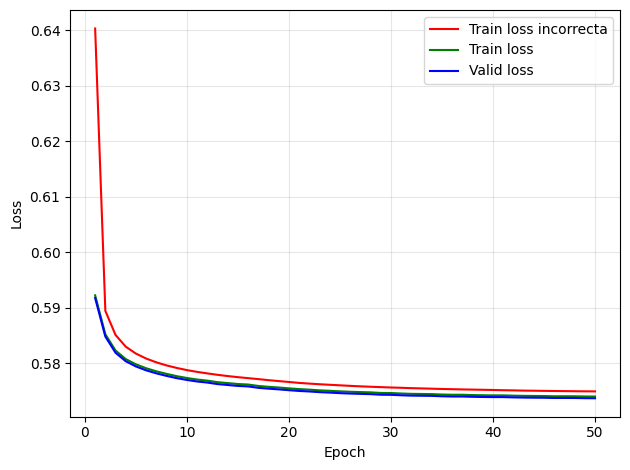

In [16]:
# 5.10)
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.xlim(-0.1,5.1)
# plt.ylim(-0.1,1.1)
plt.plot(list(range(1,len(list_avg_train_loss_incorrecta)+1)),list_avg_train_loss_incorrecta,label='Train loss incorrecta',linestyle='-',c='red')
plt.plot(list(range(1,len(list_avg_train_loss)+1)),list_avg_train_loss,label='Train loss',linestyle='-',c='green')
plt.plot(list(range(1,len(list_avg_valid_loss)+1)),list_avg_valid_loss,label='Valid loss',linestyle='-',c='blue')
plt.title('')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend()

## Cómo cargar el encoder entrenado desde otro notebook (por ejemplo, `train.ipynb`)

Ejemplo de uso en otro archivo:

```python
import torch
from torch import nn

# Asegúrate de tener la misma definición de Autoencoder
from autoencoder import Autoencoder  # o copia la clase Autoencoder a tu notebook

checkpoint_path = "/home/usuario/Documentos/RedesNeuronales/TPFinal/Clasificadora/1_design/autoencoder_fashionmnist.pt"
checkpoint = torch.load(checkpoint_path, map_location="cpu")

autoencoder = Autoencoder(dropout=checkpoint["hyperparams"]["dropout"])
autoencoder.load_state_dict(checkpoint["model_state_dict"])
encoder = autoencoder.encoder

# Ejemplo: pasar encoder a tu modelo Clasificadora
clasificador = Clasificadora(p=0.2, n1=128, n2=64, encoder=encoder)
```

De esta forma puedes entrenar el autoencoder aquí y reutilizar sus parámetros en tu notebook de clasificación (`train.ipynb`).